# Price Prediction for Real Estate Agency 

## Overview

## Business Problem

## Data Understanding
For this analysis, we will utilize a database from BLAH BLAH BLAH. It contains BLAH BLAH BLAH, Describe dataset.


In [1]:
#import necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
from sklearn.feature_selection import RFE


%matplotlib inline

In [2]:
#ignore pairplot and graph warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
housing = pd.read_csv('data/kc_house_data.csv')
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
housing.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [6]:
housing.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Observations: We have several columns with categorical values
- waterfront      
- view             
- condition       
- grade          
- floors 
- zipcode

Also the column sqft_basement is an object. Let's find out why.

We have several null values in the waterfont and yr_renovated categories. we have a small number of null values in the view category. Yr_renovated seems self-explanatory - a nan value means that the
house was not renovated. Let's explore the remaining two categories. 


## Data Preparation 

- figuring out how to replace null values in columns
- investigating duplicate id
- creating null columns

In [7]:
housing['date'] =  pd.to_datetime(housing['date'])
housing

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [8]:
housing['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [9]:
idcheck1 = housing[housing['id'] == 795000620]
idcheck1

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17588,795000620,2014-09-24,115000.0,3,1.0,1080,6250,1.0,NO,NONE,...,5 Fair,1080,0.0,1950,0.0,98168,47.5045,-122.33,1070,6250
17589,795000620,2014-12-15,124000.0,3,1.0,1080,6250,1.0,NO,NONE,...,5 Fair,1080,0.0,1950,0.0,98168,47.5045,-122.33,1070,6250
17590,795000620,2015-03-11,157000.0,3,1.0,1080,6250,1.0,NaN,NONE,...,5 Fair,1080,0.0,1950,NaN,98168,47.5045,-122.33,1070,6250


In [10]:
idcheck2 = housing[housing['id'] == 1825069031]
idcheck2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3946,1825069031,2014-08-14,550000.0,4,1.75,2410,8447,2.0,NO,GOOD,...,8 Good,2060,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789
3947,1825069031,2014-10-16,550000.0,4,1.75,2410,8447,2.0,NaN,GOOD,...,8 Good,2060,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789


In [11]:
print(housing['waterfront'].isna().sum())
housing['waterfront'].value_counts()

2376


NO     19075
YES      146
Name: waterfront, dtype: int64

In [12]:
housing[(housing['waterfront'].isna()) & (housing['view'] == "NONE")]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
10,1736800520,2015-04-03,662500.0,3,2.50,3560,9796,1.0,NaN,NONE,...,8 Good,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925
23,8091400200,2014-05-16,252700.0,2,1.50,1070,9643,1.0,NaN,NONE,...,7 Average,1070,0.0,1985,NaN,98030,47.3533,-122.166,1220,8386
40,5547700270,2014-07-15,625000.0,4,2.50,2570,5520,2.0,NaN,NONE,...,9 Better,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669
55,9822700295,2014-05-12,885000.0,4,2.50,2830,5000,2.0,NaN,NONE,...,9 Better,2830,0.0,1995,0.0,98105,47.6597,-122.290,1950,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21567,2025049203,2014-06-10,399950.0,2,1.00,710,1157,2.0,NaN,NONE,...,7 Average,710,0.0,1943,0.0,98102,47.6413,-122.329,1370,1173
21578,5087900040,2014-10-17,350000.0,4,2.75,2500,5995,2.0,NaN,NONE,...,8 Good,2500,0.0,2008,0.0,98042,47.3749,-122.107,2530,5988
21586,844000965,2014-06-26,224000.0,3,1.75,1500,11968,1.0,NaN,NONE,...,6 Low Average,1500,0.0,2014,0.0,98010,47.3095,-122.002,1320,11303
21587,7852140040,2014-08-25,507250.0,3,2.50,2270,5536,2.0,NaN,NONE,...,8 Good,2270,0.0,2003,0.0,98065,47.5389,-121.881,2270,5731


In [13]:
housing['waterfront'].fillna(value='NO', inplace=True)

**Waterfront view**

- the only options are yes or no. 
Any property on a waterfront will have a value other than NONE in the view column. Since there are 2110 rows that have a NaN value in waterfront and a none value in the view column in our data, it seems safer to assume NO as the default for waterfront.

We can either assume a property with a nan value for waterfront means it is not on the waterfront and replace all the nan values with no, or we can just drop the rows with a nan response. 
Since our data comprises of ~21,600 different rows, if we dropped these 2376 rows, we'd be loosing 
more than 10% of our data. 

So let's keep them and assume a nan response means no waterfront view. 

In [14]:
#454 columns with ? for a value. 
housing['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1008.0        1
2180.0        1
1281.0        1
784.0         1
768.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [15]:
# create new column sqrt_basement2 which is sqrt_living - sqrt-above. Addresses sqft_basement ? values.
housing['sqft_basement2'] = housing['sqft_living'] - housing['sqft_above']
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,910
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,0


In [16]:
# has 3842 nan values, also has some 0.0 values
print(housing['yr_renovated'].isna().sum())
housing['yr_renovated'].value_counts()

3842


0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [17]:
#creating new column was_renovated. Assuming Nan value and 0.0 - means home was not renovated.
housing['yr_renovated'].fillna(0, inplace=True)
housing['was_renovated'] = housing['yr_renovated'] != 0.0

In [18]:
#replacing 0.0 in yr_renovated column with associated value in yr_built
housing.loc[housing['yr_renovated'] == 0, ['yr_renovated']] = housing['yr_built']

In [19]:
#checking dataframe
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,0,False
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400,True
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,0,False
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,1965.0,98136,47.5208,-122.393,1360,5000,910,False
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,0,False


In [20]:
print(housing['view'].isna().sum())
housing['view'].value_counts()

63


NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [21]:
housing['view'].fillna(value='NONE', inplace=True)

**View**

- several options - none, nan, good, excellent, average, and fair.

We can either assume a nan response means no view and replace all the nan values with none, 
or we can just drop the rows with a nan response.  
Since our data comprises of ~21,600 different rows, if we dropped these 63 rows, 
we'd only be loosing 0.3% of our data.

Let's keep them and assume a nan response means no view.

**Sqft_basement**
- created new column to address the '?' values and the 0.0 values.

**Yr_renovated**
- created new column that addresses the 0.0 values and the nan values.

In [22]:
#investigating outlier bedrooms
housing[housing['bedrooms'] > 8]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
4092,1997200215,2014-05-07,599999.0,9,4.50,3830,6988,2.5,NO,NONE,...,1380.0,1938,1938.0,98103,47.6927,-122.338,1460,6291,1380,False
4231,2902200015,2015-01-06,700000.0,9,3.00,3680,4400,2.0,NO,NONE,...,850.0,1908,1908.0,98102,47.6374,-122.324,1960,2450,850,False
6073,9822700190,2014-08-08,1280000.0,9,4.50,3650,5000,2.0,NO,NONE,...,1120.0,1915,2010.0,98105,47.6604,-122.289,2510,5000,1120,True
8537,424049043,2014-08-11,450000.0,9,7.50,4050,6504,2.0,NO,NONE,...,0.0,1996,1996.0,98144,47.5923,-122.301,1448,3866,0,False
8748,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,NO,NONE,...,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960,600,True
13301,627300145,2014-08-14,1150000.0,10,5.25,4590,10920,1.0,NO,AVERAGE,...,2090.0,2008,2008.0,98004,47.5861,-122.113,2730,10400,2090,False
15147,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,NO,NONE,...,600.0,1958,1958.0,98006,47.5705,-122.175,2040,11914,600,False
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,NO,NONE,...,580.0,1947,1947.0,98103,47.6878,-122.331,1330,4700,580,False
16830,8823900290,2015-03-17,1400000.0,9,4.00,4620,5508,2.5,NO,NONE,...,750.0,1915,1915.0,98105,47.6684,-122.309,2710,4320,750,False
18428,8823901445,2015-03-13,934000.0,9,3.00,2820,4480,2.0,NO,NONE,...,940.0,1918,1918.0,98105,47.6654,-122.307,2460,4400,940,False


In [23]:
#replacing 33 bedrooms with 3. we feel confident in assuming this was a typo based on the bathrooms and sqft_living
housing['bedrooms'] = housing['bedrooms'].replace(33, 3)

In [24]:
housing.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,0,False
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400,True
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,0,False
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,1965.0,98136,47.5208,-122.393,1360,5000,910,False
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,0,False
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,1530.0,2001,2001.0,98053,47.6561,-122.005,4760,101930,1530,False
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,?,1995,1995.0,98003,47.3097,-122.327,2238,6819,0,False
7,2008000270,2015-01-15,291850.0,3,1.50,1060,9711,1.0,NO,NONE,...,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711,0,False
8,2414600126,2015-04-15,229500.0,3,1.00,1780,7470,1.0,NO,NONE,...,730.0,1960,1960.0,98146,47.5123,-122.337,1780,8113,730,False
9,3793500160,2015-03-12,323000.0,3,2.50,1890,6560,2.0,NO,NONE,...,0.0,2003,2003.0,98038,47.3684,-122.031,2390,7570,0,False


In [25]:
housing.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_basement2',
       'was_renovated'],
      dtype='object')

## Feature Analysis
Target variable is price. exploring different feature correlation

In [ ]:
sns.pairplot(housing, 'price')

In [ ]:
#exploring target variable


In [26]:
housing.corr().price.sort_values(ascending=False)

price             1.000000
sqft_living       0.701917
sqft_above        0.605368
sqft_living15     0.585241
bathrooms         0.525906
sqft_basement2    0.323799
bedrooms          0.315954
lat               0.306692
floors            0.256804
was_renovated     0.117543
yr_renovated      0.097541
sqft_lot          0.089876
sqft_lot15        0.082845
yr_built          0.053953
long              0.022036
id               -0.016772
zipcode          -0.053402
Name: price, dtype: float64

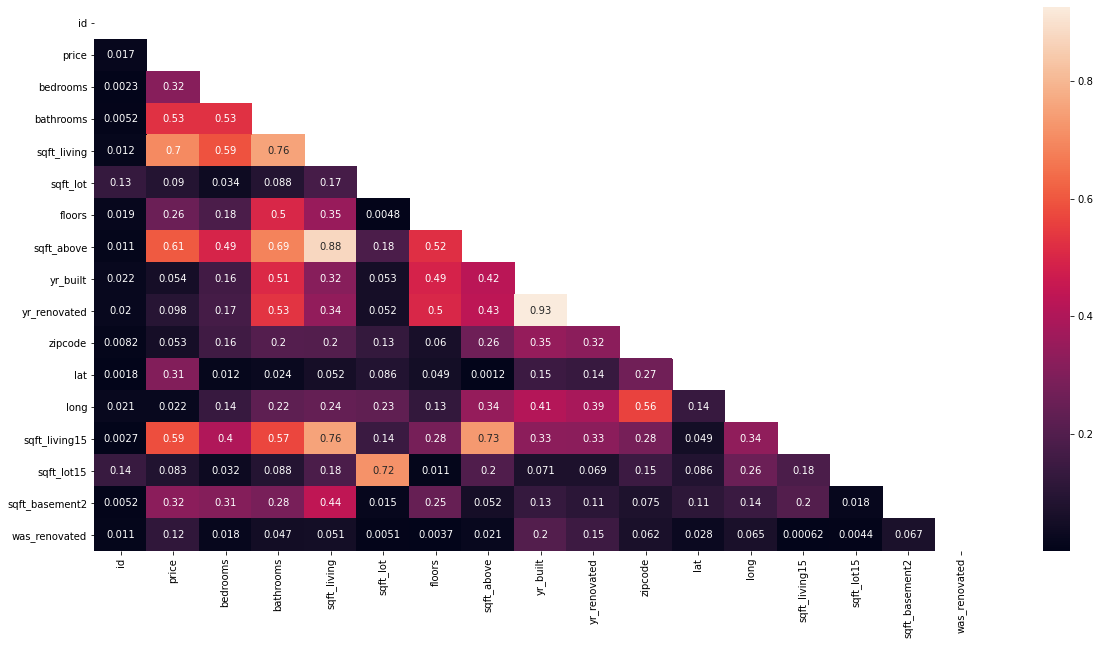

In [27]:
mask = np.triu(np.ones_like(housing.corr(), dtype=bool))

plt.figure(figsize=(20,10))

cor = housing.corr().abs()
sns.heatmap(cor, mask=mask, annot=True);

In [31]:
## creating new column - bedroom:bathroom ratio to adjust for multicollinearity between the two indepentt variables

housing['bed_bath_ratio'] = (housing['bedrooms'] /  housing['bathrooms'])
housing

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated,bed_bath_ratio
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,1955,1955.0,98178,47.5112,-122.257,1340,5650,0,False,3.000000
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,400,True,1.333333
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,1933.0,98028,47.7379,-122.233,2720,8062,0,False,2.000000
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,1965.0,98136,47.5208,-122.393,1360,5000,910,False,1.333333
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,1987.0,98074,47.6168,-122.045,1800,7503,0,False,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,2009,2009.0,98103,47.6993,-122.346,1530,1509,0,False,1.200000
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2014,2014.0,98146,47.5107,-122.362,1830,7200,0,False,1.600000
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,2009,2009.0,98144,47.5944,-122.299,1020,2007,0,False,2.666667
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NO,NONE,...,2004,2004.0,98027,47.5345,-122.069,1410,1287,0,False,1.200000


In [ ]:
#Setting up train test split
X = housing.drop('price', axis=1)
y = housing['price']

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=57)

In [ ]:
Housing_train= 

In [ ]:
lb_make = Labelencoder()


EXPLORATORY

In [ ]:
sns.pairplot(housing)
plt.show()

In [ ]:
housing.corr()

In [ ]:
housing.corr().price.sort_values(ascending=False)

In [ ]:
Simple Model - no encoding

In [ ]:
housing['sqft_above'].sort_values()

In [ ]:
#Multiple Regression model all variables (no encoding)
housing1 = housing.drop(['id','date', 'grade', 'condition', 'waterfront', 'view', 'sqft_basement', 'bedrooms', 'bathrooms', 'floors', 'yr_renovated', 'zipcode', 'lat', 'long'], axis=1)
housing1.head()

In [ ]:
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select =4)

In [ ]:
ss = StandardScaler()
ss.fit(housing1.drop('price', axis=1))
housing1_scaled = ss.transform(housing1.drop('price', axis=1))

In [ ]:
housing1_scaled

In [ ]:
select.fit(X=housing1_scaled, y=housing1['price'])

In [ ]:
select.support_

In [ ]:
select.ranking_

In [ ]:
## use sqft_living  yr_built  sqft_living15  sqft_lot15

In [ ]:
Polynomials using all except categorical values

In [ ]:
X = housing1.drop('price', axis=1)
y = housing1['price']
pf = PolynomialFeatures(degree=3)
pf.fit(X)

In [ ]:
pf.transform(X)

In [ ]:
pf.transform(X).shape

In [ ]:
pf.get_feature_names()

In [ ]:
polynomial_df = pd.DataFrame(pf.transform(X), columns= pf.get_feature_names() )

In [ ]:
lr = LinearRegression()
lr.fit(polynomial_df, y)

In [ ]:
lr.score(polynomial_df, y)